# Exponential Smoothing

We dive into more advanced techniques with exponential smoothing. 

This quote from <a href="https://otexts.com/fpp2/expsmooth.html">Forecasting: Principles and Practice</a>, helps summarize the technique.
<br>
<br>
<q>Exponential smoothing was proposed in the late 1950s (Brown, 1959; Holt, 1957; Winters, 1960), and has motivated some of the most successful forecasting methods. Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight. This framework generates reliable forecasts quickly and for a wide range of time series, which is a great advantage and of major importance to applications in industry.</q>   
 
## What You'll Accomplish 

In particular you'll see:
<ul>
    <li>An introduction to time series analysis with the statsmodel.api package,</li>
    <li>A blend of the average and na&iuml;ve with simple exponential smoothing,</li>
    <li>Methods for modeling trends, and</li>
    <li>Methods for handling seasonality.</li>
</ul>

Let's start by importing our standard packages.

In [1]:
# import the packages we'll use
from datetime import datetime

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## Simple Exponential Smoothing

Assume that our training data has $T_\text{train}$ observations, and we're predicting with a horizon $h$.

Recall that the na&iuml;ve method has the following forecast algorithm,
$$
\hat{y}_{T_\text{train} + h|T_\text{train}} = y_{T_\text{train}},
$$
and that the average method forecasts like so:
$$
\hat{y}_{T_\text{train} + h|T_\text{train}} = \frac{1}{T_\text{train}}\sum_{t=1}^{T_\text{train}} y_t.
$$

These two approaches can be seen as completely opposite extremes. 

On one hand, with the na&iuml;ve method you disregard almost all of the data only going with the most recent observation as the information you predict with. If you think about multiplying each observation with a weight this corresponds placing all the weight on the last observation while giving all the other observations a weight of $0$. 


On the other hand, the average method takes the opposite approach by equally weighting all the observations.

These were great first attempts at forecasting, but the true relationship for most time series is somewhere in between. This is where the idea for simple exponential smoothing arrives. With simple exponential smoothing we forecast like this
$$
\hat{y}_{T_\text{train} + h|T_\text{train}} = \alpha y_{T_\text{train}} + \alpha(1-\alpha) y_{T_\text{train} - 1} + \alpha(1-\alpha)^2 y_{T_\text{train} - 2} + \dots, \alpha \in (0,1).
$$


### Another Way to Write it

Another way to write this that will be helpful for us later is called the <i>component form</i>.

$$
\begin{array}{l l}
\text{the Forecast equation } & \hat{y}_{t+h|t} = l_t,  \\
\text{the Smoothing equation } & l_t = \alpha y_t + (1-\alpha)l_{t-1}, 
\end{array}
$$
where $l_0$ is another parameter of the model that is estimated from training data. When we let $h=1$ we get the fitted values on the training data, and when $t = {T_\text{train}}$ we get the forecast on test data.

In the component form we write that the forecast on test data is:
$$
\hat{y}_{T_\text{train} + h|T_\text{train}} = \hat{y}_{T_\text{train} + 1|T_\text{train}} = l_{T_\text{train}}
$$

This form may seem confusing, but it will help when we add in trend and seasonality modeling.

### Simple Exponential Smoothing on Oil Production Data

We'll implement this algorithm on the annual oil production from Saudi Arabia 1965-2013.

In [2]:
oil = pd.read_csv("oil.csv", parse_dates=['year'])

/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


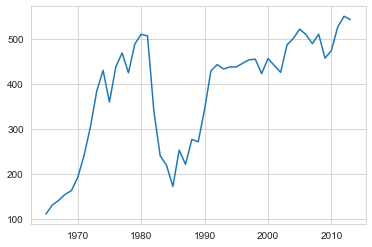

In [3]:
plt.plot(oil.year,oil.production)

plt.show()

In [4]:
oil_train = oil.loc[oil.year < datetime(2010,1,1),].copy()
oil_test = oil.drop(oil_train.index).copy()

#### Return of  `statsmodels`

Now that our models are slightly more complicated we no longer have to write them by hand, `statsmodels` has time series algorithms ready for us to use.

In [ ]:
# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing

In [ ]:
# We make a SimpleExpSmoothing object like this
# the data you want to train on is the input
ses = SimpleExpSmoothing(oil_train.production.values)

In [ ]:
# Then you make a fitted object
# you can put in a value for alpha
# like so
fit = ses.fit(smoothing_level=0.5, optimized=False)

# or you can go the this route and
# let the algorithm find the optimal alpha
# for the training data
# fit = ses.fit(optimized=True)

In [ ]:
# we can now make a plot of the fitted values 
# and the forecast on the test data
plt.figure(figsize=(8,6))

# plot the training data
plt.plot(oil_train.year, oil_train.production,'b',
            label = "Training Data")

# plot the fit
plt.plot(oil_train.year, fit.fittedvalues,'r-',
            label = "Fitted Values")

# plot the forecast
plt.plot(oil_test.year, fit.forecast(len(oil_test)),'r--',
            label = "Forecast")

plt.plot(oil_test.year, oil_test.production,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Year", fontsize=16)
plt.ylabel("Production \n in millions of tonnes", fontsize=16)

plt.show()

## Practice

Use exponential smoothing to predict the last $150$ days of google closing prices from this data set of $1000$ consecutive trading days. It's okay if the fit isn't very good. This is about getting used to the process of fitting models with `statsmodels` time series methods.

In [ ]:
goog = pd.read_csv("goog.csv")

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(goog.closing_price)

plt.xlabel("Day", fontsize=16)
plt.ylabel("Closing Price", fontsize=16)

plt.show()

In [ ]:
## Code here








In [ ]:
## And here








In [ ]:
## And here if needed








## Trend Models

After the introduction of Simple Exponential Smoothing a few researchers developed extensions that allow the forecast to have a trend as opposed to being a flat prediction.

### Holt's Linear Trend Model

Developed by Holt in 1957 this approach breaks the smoothing equation into two equations.
$$
\begin{array}{l l}
\text{The forecast equation} & \hat{y}_{t+h|t} = l_t + h b_t ,\\
\text{the level equation} & l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1}), \\
\text{the trend equation} & b_t = \beta^* (l_t - l_{t-1}) + (1-\beta^*)b_{t-1}
\end{array}.
$$

Here both $\alpha$ and $\beta$ are parameters that are allowed to take any value in $(0,1)$.

The level equation is the equivalent of what we referred to as the smoothing equation for simple exponential smoothing.

The trend equation, models the trend, in particular it does this by modeling the trend with the smoothing equation from simple exponential smoothing, but this time using the pairwise differences $l_t - l_{t-1}$.

If you notice here the $hb_t$ in the forecast equation is where the linear in Holt's linear trend model comes from. It is this that allows for non-level forecasts into the future. 

However, it is also slightly unrealistic for all time series that the trend is a linear increase or decrease forever which led to the next extension.

### Damped Trend Methods

This extension on Holt's linear trend method allows for a trend that dampens over time. It was developed by Gardner & McKenzie in 1985.

Instead of having the forecast be a linear function of the horizon you use a power series:
$$
\begin{array}{l l}
\text{The forecast equation} & \hat{y}_{t+h|t} = l_t + (\phi + \phi^2 + \dots + \phi^h) b_t ,\\
\text{the level equation} & l_t = \alpha y_t + (1-\alpha)(l_{t-1} + \phi b_{t-1}), \\
\text{the trend equation} & b_t = \beta^* (l_t - l_{t-1}) + (1-\beta^*) \phi b_{t-1}
\end{array}.
$$

Here all of $\alpha$, $\beta$, and $\phi$ are parameters in $(0,1)$ that you must choose, the best parameters depend on the data.

### Forecasting Livestock in Asia

We'll demonstrate how to implement these two methods using data on annual sheep levels in Asia from 1961-2007, then you'll return to the Google stock data in a breakout session.

In [ ]:
livestock = pd.read_csv("livestock.csv",parse_dates = ['year'])

In [ ]:
livestock_train = livestock.loc[livestock.year < datetime(2003,1,1),].copy()
livestock_test = livestock.drop(livestock_train.index).copy()

In [ ]:
plt.figure(figsize = (8,6))

plt.plot(livestock_train.year, livestock_train.million_head)

plt.xlabel("Date", fontsize=16)
plt.ylabel("Million Head of Sheep", fontsize=16)

plt.show()

There's a clear trend in this data. We'll now use the time series functionality from `statsmodels` to implement the Holt linear model and the damped linear model.

In [ ]:
# Import the Holt object
from statsmodels.tsa.api import Holt

# Holt can make both linear models and damped linear models

In [ ]:
# Holt's linear model 
lin_mod = Holt(livestock_train.million_head.values,
                  damped = False)

# damped linear model
damp = Holt(livestock_train.million_head.values,
               damped = True)

In [ ]:
## Fit the linear model ##
# Again you can fit the models with custom parameters
# smoothing_level is alpha
# smoothing_slope is beta
#lin_mod_fit = lin_mod.fit(smoothing_level = .4, 
 #                           smoothing_slope = .4,
  #                          optimized=False)

# or you can let the algorithm find the optimal
# parameters for the training data
lin_mod_fit = lin_mod.fit(optimized=True)

## Fit the damped model ##
# damping_slope is phi from the model
#damp_fit = damp.fit(smoothing_level = .4,
 #                      smoothing_slope = .4,
  #                     damping_slope = .4,
   #                    optimized = False)

# again you can let the algorithm find the optimal
# parameters for the training data
damp_fit = damp.fit(optimized = True)

In [ ]:
# we can now make a plot of the fitted values 
# and the forecast on the test data
plt.figure(figsize=(10,8))

## Plot the training data and the fits
# plot the training data
plt.plot(livestock_train.year, livestock_train.million_head,'b-',
            label = "Training Data")

# plot the linear fit
plt.plot(livestock_train.year, lin_mod_fit.fittedvalues,'r-',
            label = "Holt Linear Fitted Values")

# plot the damped fit
plt.plot(livestock_train.year, damp_fit.fittedvalues,'k-',
            label = "Damped Linear Fitted Values")


## Plot the test data and forecasts
# test data
plt.plot(livestock_test.year, livestock_test.million_head,'b--',
            label = "Test Data")

# plot the linear forecast
plt.plot(livestock_test.year, lin_mod_fit.forecast(len(livestock_test)),
         'r--', label = "Holt Linear Forecast")

# plot the damp forecast
plt.plot(livestock_test.year, damp_fit.forecast(len(livestock_test)),
         'k--', label = "Damped Linear Forecast")


plt.legend(fontsize=14)

plt.xlabel("Year", fontsize=16)
plt.ylabel("Million Head of Sheep", fontsize=16)

plt.show()

In [ ]:
# If you go the optimized=True
# route like we did you can find the
# parameters like so.
damp_fit.params

## Practice

Implement Holt's linear model and the damped linear model on the Google stock data. Which looks like it works better?

Play around with changing the parameters by hand and using the optimized model. You may want to implement cross-validation. You can if you'd like, but this practice is more about getting familiar with implementing the `statsmodel` framework than making the best model.

In [ ]:
## Code here








In [ ]:
## Code here








In [ ]:
## Code here








In [ ]:
## Code here








## Holt-Winters' Seasonality Extension to Holt's Linear Model

Both Holt, in 1957, and Winters, in 1960, built extensions onto Holt's Linear Model to account for seasonality in the data. This time the component has an additional component added on to account for seasonality. In their approach they again denote the level and trends as $l_t$ and $b_t$ respectively. The frequency of the data is denoted as $m$, recall that this is the number of seasons that occur within a year, for example if the data goes through its season once a quarter $m=4$. If we remember our measles example the season occurred once every two years, in this case $m=1/2$.

There are two versions of the seasonality extension, an additive one and a multiplicative one.

### Additive Model

This approach is preferred when the magnitude of the seasonality is more or less constant over time.

$$
\begin{array}{l l}
\text{The forecast equation} & \hat{y}_{t+h|t} = l_t + h b_t + s_{t+h - m(k+1)},\\
\text{the level equation} & l_t = \alpha (y_t - s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1}), \\
\text{the trend equation} & b_t = \beta^* (l_t - l_{t-1}) + (1-\beta^*)b_{t-1}, \\
\text{the seasonality equation} & s_t = \gamma(y_t - l_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m}.
\end{array}.
$$
Where here $\gamma \in (0,1-\alpha)$, and $k = (h-1) // m$, the integer part of $(h-1)/m$, which ensures that the estimates of the seasonal indices used for forecasting come from the final year of the sample.

### Multiplicative Model

This approach works well with seasonality that either grows are shrinks with time.

$$
\begin{array}{l l}
\text{The forecast equation} & \hat{y}_{t+h|t} = (l_t + h b_t)s_{t+h - m(k+1)},\\
\text{the level equation} & l_t = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(l_{t-1} + b_{t-1}), \\
\text{the trend equation} & b_t = \beta^* (l_t - l_{t-1}) + (1-\beta^*)b_{t-1}, \\
\text{the seasonality equation} & s_t = \gamma\frac{y_t}{(l_{t-1}+b_{t-1})} + (1-\gamma)s_{t-m}.
\end{array}.
$$
Here $k$ and $\gamma$ are as in the Additive Model.

#### A Note on Damping

Note that there are damped versions of these models as well, we just don't present their equations. You can find them here, <a href="https://otexts.com/fpp2/holt-winters.html">https://otexts.com/fpp2/holt-winters.html</a>.

### Fitting Seasonal Models on Australian Beer Data

We'll return to our australian beer production data.

In [ ]:
ausbeer = pd.read_csv("ausbeer.csv")

In [ ]:
ausbeer_train = ausbeer.iloc[:-12,].copy()
ausbeer_test = ausbeer.drop(ausbeer_train.index).copy()

In [ ]:
plt.figure(figsize = (8,6))

plt.plot(ausbeer_train.production)

plt.xlabel("Quarter", fontsize=16)
plt.ylabel("Production", fontsize=16)

plt.show()

In [ ]:
# Now we import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
# Make two model objects
# in both models because our season occurs every
# 4 time steps we set season_periods = 4


# In the additive model set seasonal to 'add'
add_mod = ExponentialSmoothing(ausbeer_train,seasonal_periods=4, seasonal='add')

# In the multiplicative model set seasonal to 'mul'
mul_mod = ExponentialSmoothing(ausbeer_train,seasonal_periods=4, seasonal='mul')

In [ ]:
## now fit them
## By not putting in parameters we
## go with the method defaults which is to
## use optimized=True

# The Additive Model
add_mod_fit = add_mod.fit()

# The multiplicative model
mul_mod_fit = mul_mod.fit()

In [ ]:
## Plot Them
fig,ax = plt.subplots(2,1,figsize=(12,16),sharex=True, sharey=True)

## The additive model
# training data
ax[0].plot(ausbeer_train.index, ausbeer_train.production, 
           'b-', label="Training Data")

# fitted values
ax[0].plot(ausbeer_train.index, add_mod_fit.fittedvalues, 
           'r-', label="Fitted Values")

# The test data
ax[0].plot(ausbeer_test.index, ausbeer_test.production,
            'b--', label="Test Data")
ax[0].plot(ausbeer_test.index, add_mod_fit.forecast(len(ausbeer_test)),
           'r--', label="Forecast")

ax[0].legend(fontsize=14)

ax[0].set_title("Additive Model",fontsize=18)
ax[0].set_ylabel("Production",fontsize=16)



## The multiplicative model
# training data
ax[1].plot(ausbeer_train.index, ausbeer_train.production, 
           'b-', label="Training Data")

# fitted values
ax[1].plot(ausbeer_train.index, mul_mod_fit.fittedvalues, 
           'r-', label="Fitted Values")

# The test data
ax[1].plot(ausbeer_test.index, ausbeer_test.production,
            'b--', label="Test Data")
ax[1].plot(ausbeer_test.index, mul_mod_fit.forecast(len(ausbeer_test)),
           'r--', label="Forecast")


ax[1].set_title("Multiplicative Model",fontsize=18)
ax[1].set_ylabel("Production",fontsize=16)
ax[1].set_xlabel("Quarter",fontsize=16)

plt.show()

plt.show()

## Practice

Return to the measles data (pre 1963). Implement these two techniques on that data.

In [ ]:
measles = pd.read_csv("measles.csv", parse_dates=['month'])

In [ ]:
measles_1963 = measles.loc[measles.month < datetime(1963,1,1),].copy()

In [ ]:
## Code here








In [ ]:
## Code here








In [ ]:
## Code here








In [ ]:
## Code here








That's it for this notebook. We don't have the time to go into detail on the theoretical details of exponential smoothing. For those that are interested read sections 7.5 and 7.6 of <a href="https://otexts.com/fpp2/ets.html">Forecasting: Principles and Practice</a>.

Also you can learn more about the `statsmodels` Exponential Smoothing capabilities at the documentation page here <a href="https://www.statsmodels.org/stable/tsa.html">https://www.statsmodels.org/stable/tsa.html</a> with a nice tutorial page here <a href="https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#Exponential-smoothing">https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#Exponential-smoothing</a>.

We'll see you in Notebook 5 where we introduce our final time series material ARIMA models.

### References 

Sections 7.1 to 7.4 of <a href="https://otexts.com/fpp2/">Forecasting: Principles and Practice</a>, by Rob J Hyndman and George Athanasopoulos.

The time series section of the `statsmodels` documentation, <a href="https://www.statsmodels.org/stable/tsa.html">https://www.statsmodels.org/stable/tsa.html</a>.